In [3]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

%load_ext autoreload
%autoreload 2

import pickle

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

In [4]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)

In [5]:
merged_fitness[merged_fitness['gene']=='IRA1+MKT1']['all_mutations_verbose'].values

array(['II:441856:C:T:MMS4:synonymous_variant:c.342C>T:p.Asn114Asn:1/1~II:521600:C:A:IRA1:stop_gained:c.5029G>T:p.Glu1677*:1/1~II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~III:32114:G:T:SPB1:missense_variant:c.666G>T:p.Leu222Phe:1/1~XIV:467219:A:C:MKT1:missense_variant:c.89A>C:p.Asp30Ala:1/1'],
      dtype=object)

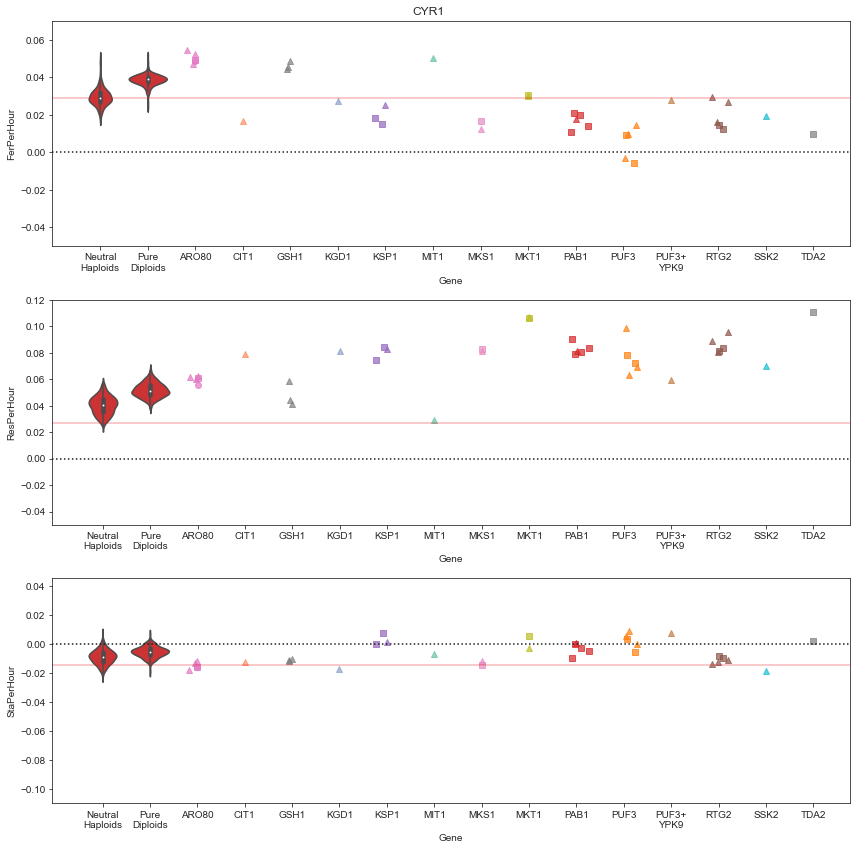

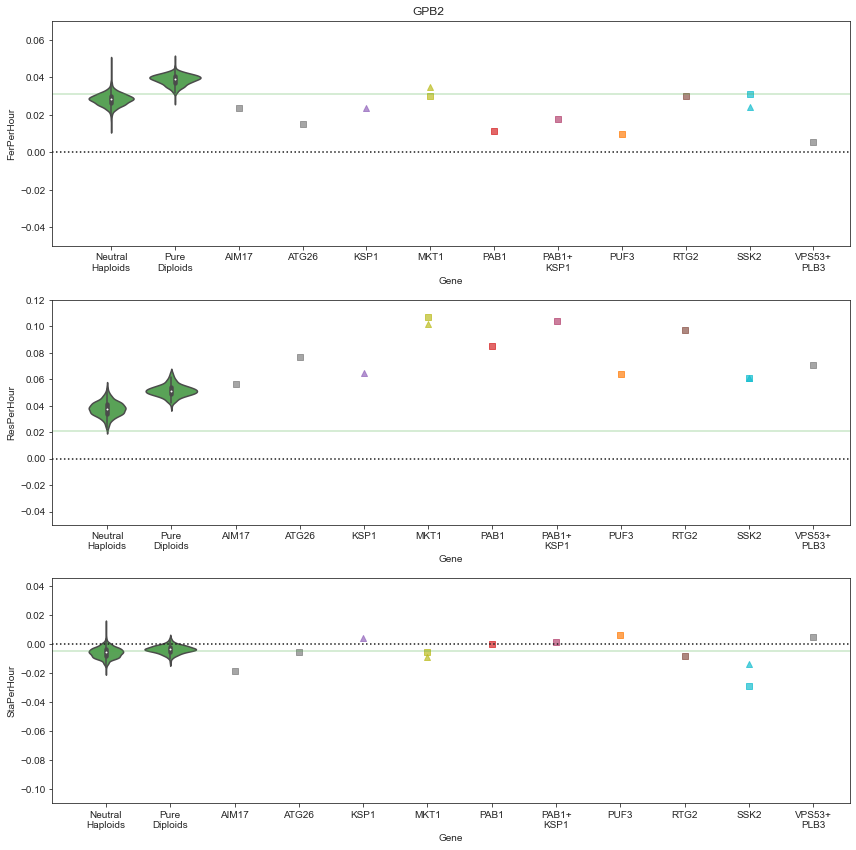

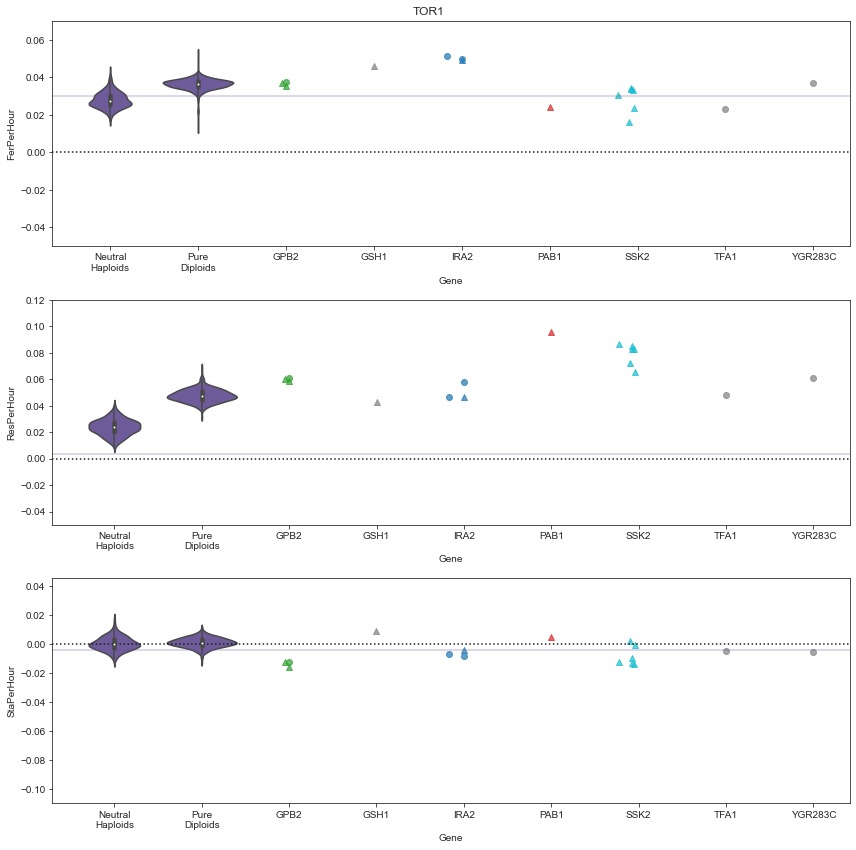

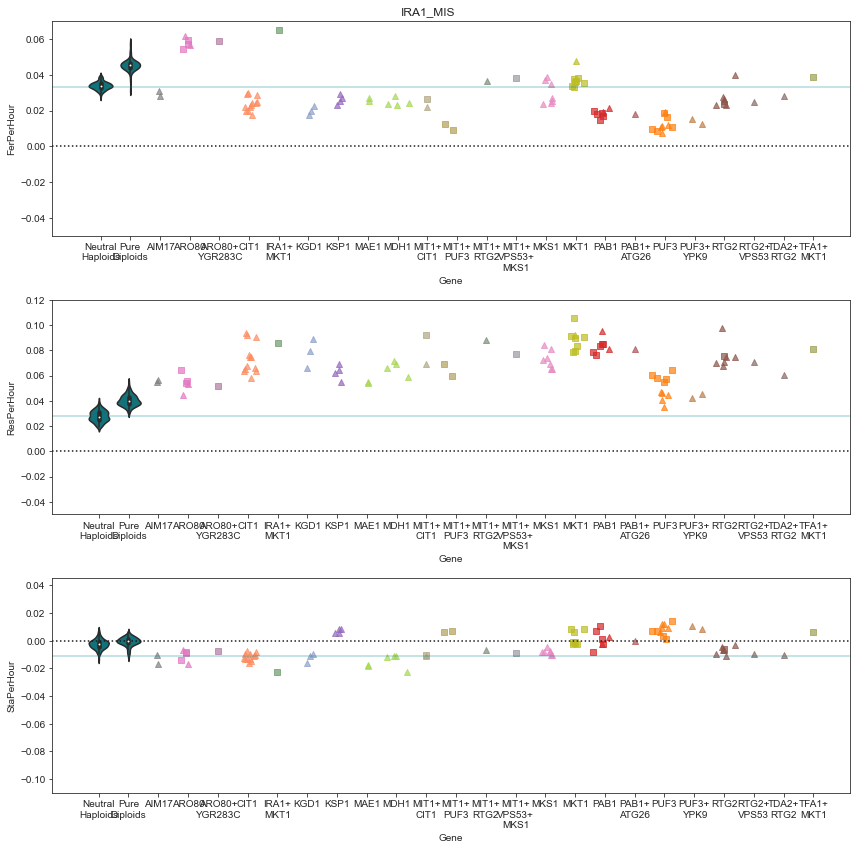

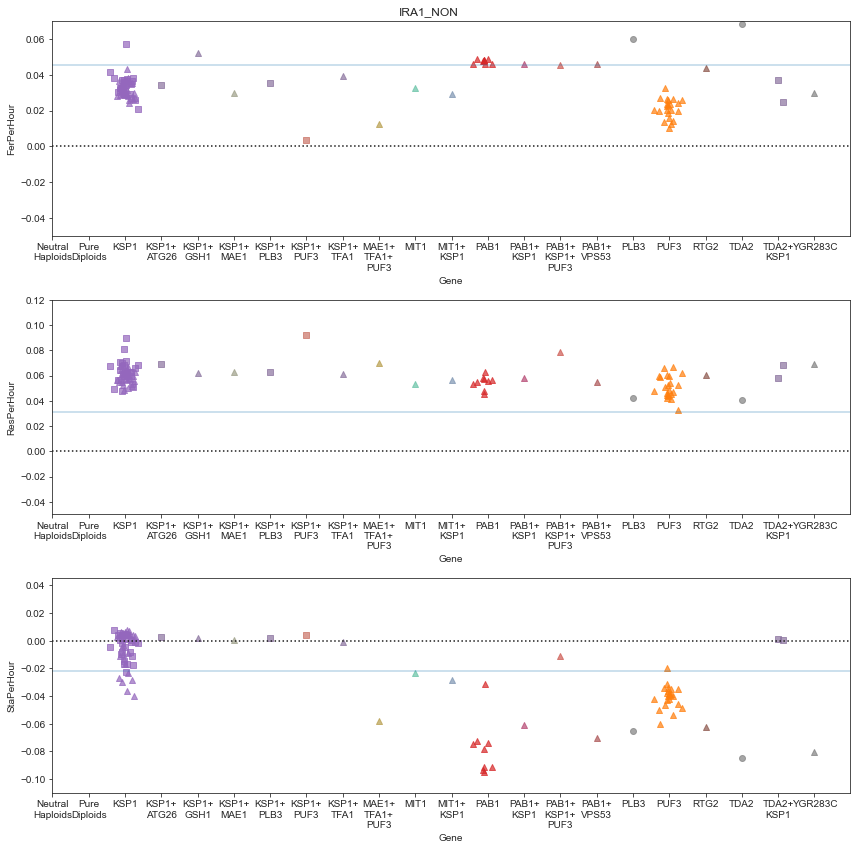

In [80]:

evo_cond_list = ['Evo1D','Evo2D','Evo3D']

plotting_list = ['FerPerHour','ResPerHour','StaPerHour']
# plotting_list = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness',
#                  'Fit3D_both2%5%_fitness','Fit5D_both2%5%_fitness']

ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
for a,ancestor in enumerate(ancestor_list):
    
    this_anc = merged_fitness[merged_fitness['ancestor']==ancestor]
    
    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    this_pure_diploid = this_anc[(this_anc['class_new']=='pure_diploids')]
    
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
    this_neutral_haploid = this_anc[(this_anc['class_new']=='neutral_haploids')]

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
    
    gene_list = np.unique([x for x in interesting_muts['gene'].values if not p.isnull(x)])
    
#     gene_list = sorted(gene_list)
        
#     double_muts = [gene for gene in gene_list if '+' in gene]

    fig = plt.figure(figsize=(4*len(plotting_list),12))
    plt.suptitle(f'{ancestor}')
    



    
#     not_featured = interesting_muts[~interesting_muts['gene'].isin([double_mut]+single_muts)]

#     plt.scatter(not_featured[xdata].values,not_featured[ydata].values,
#             color='k',alpha=0.1)



    for count,data in enumerate(plotting_list):
        
        gene_names = []
        plt.subplot(len(plotting_list),1,count+1)
        
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancestor]]

        plt.axhline(background_mutant[data].values,
                color=tools.anc_color_map[ancestor],alpha=0.3)
        
        if len(this_neutral_haploid[data].values) > 0:
            sns.violinplot(x=[0 for x in range(len(this_neutral_haploid[data].values))]+[1 for x in range(len(this_pure_diploid[data].values))],
                           y=list(this_neutral_haploid[data].values)+list(this_pure_diploid[data].values),
                    color=tools.anc_color_map[ancestor],alpha=0.2,thresh=0.2,order=[0,1])

        gene_names.append('Neutral\nHaploids')
        gene_names.append('Pure\nDiploids')

        np.random.seed(9)
        for g,gene in enumerate(gene_list):
            gene_names.append(gene.replace('+','+\n'))
            
            for evo_cond in evo_cond_list:
                
                this_gene = interesting_muts[(interesting_muts['gene']==gene) & (interesting_muts['evolution_condition']==evo_cond)]
            
                if len(this_gene) > 0:
                
                    if '+' in gene:
                        color_to_use = tools.combine_hex_values([tools.find_mutation_color(g) for g in gene.split('+')])
                        alpha_to_use = 0.7
                    else:
                        color_to_use = tools.find_mutation_color(gene)
                        alpha_to_use = 0.7
                    
                    if len(this_gene) > 1:
                        x_vals = [tools.jitter_point(g+2) for x in range(len(this_gene))]
                    else:
                        x_vals = [g+2] 
                   
                    plt.scatter(x_vals,this_gene[data].values,
                        color=color_to_use,label=f'{gene}',alpha=alpha_to_use,marker=tools.evo_cond_marker_map[evo_cond])

#         for evo_cond in evo_cond_list:
#             this_gene = interesting_muts[p.isnull(interesting_muts['gene']) & (~p.isnull(interesting_muts['all_mutations'])) &(interesting_muts['evolution_condition']==evo_cond)]

#             plt.scatter([tools.jitter_point(g+3) for x in range(len(this_gene))],this_gene[data].values,
#                         color='k',label=f'{gene}',alpha=0.1,marker=tools.evo_cond_marker_map[evo_cond])

#         gene_names.append('other')
        
        plt.xticks(range(len(gene_names)),gene_names)

        plt.xlabel('Gene')
        plt.ylabel(data)
        plt.ylim(tools.lims[data][0],tools.lims[data][1])

        plt.axhline(0,color='k',linestyle=':')
            
    plt.tight_layout()
    if 'Fit1D_both2%5%_fitness' in plotting_list:
        plt.savefig(f'{home_dir}/figures/analysis/fitness/fitness_{ancestor}.pdf',bbox_inches='tight')
#         plt.savefig(f'{home_dir}/figures/analysis/fitness/fitness_{ancestor}.png',bbox_inches='tight')
    else:
        plt.savefig(f'{home_dir}/figures/analysis/fitness/performances_{ancestor}.pdf',bbox_inches='tight')



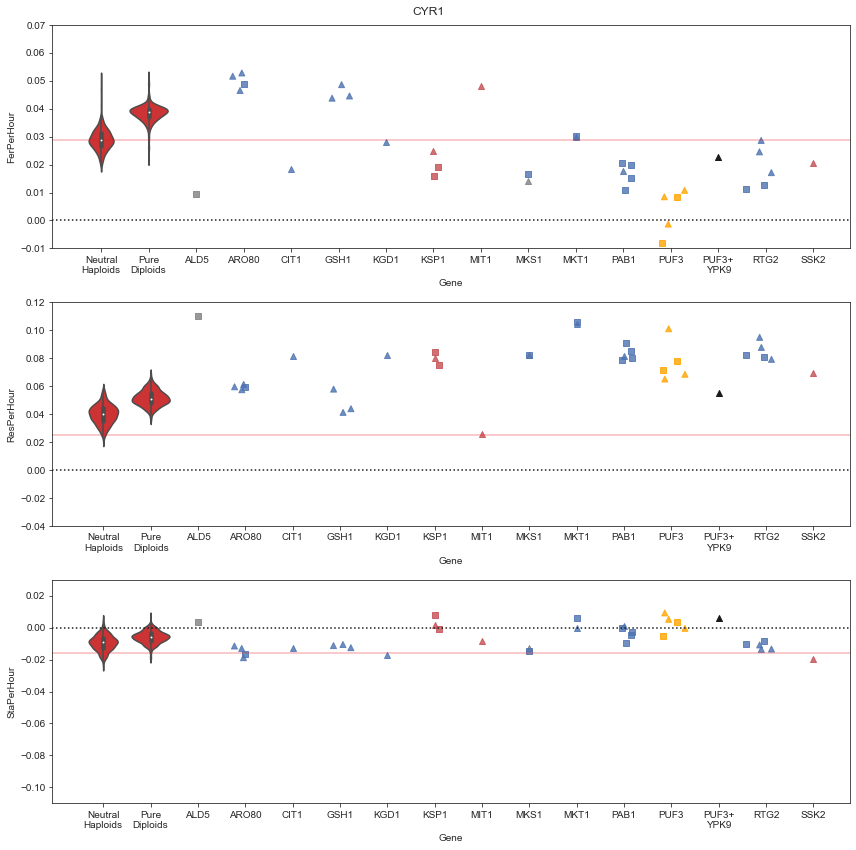

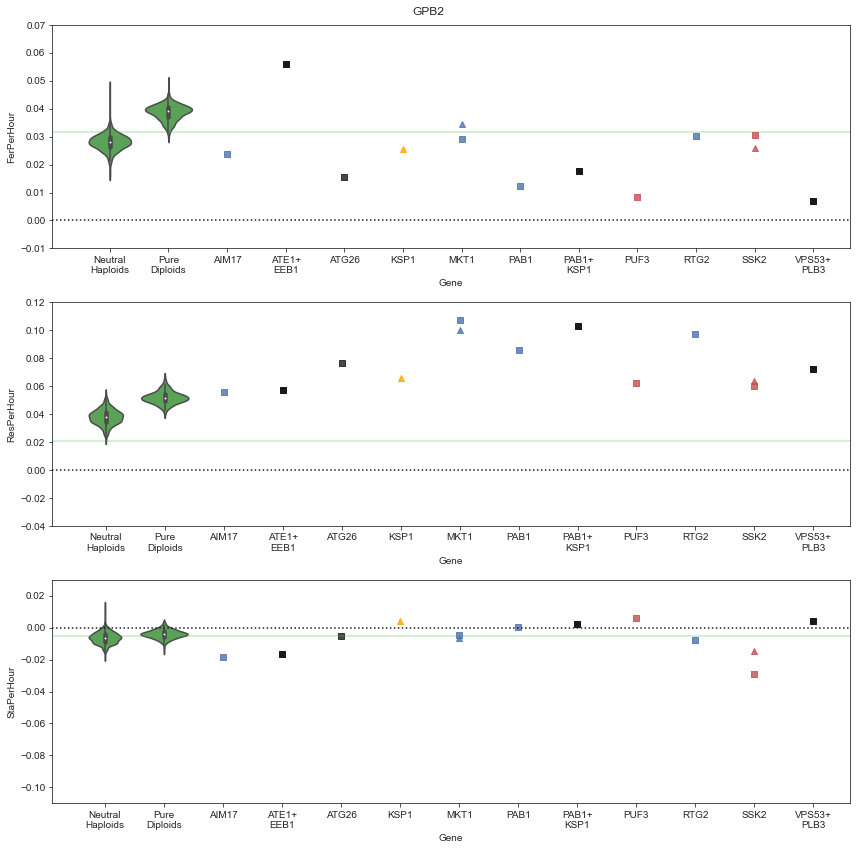

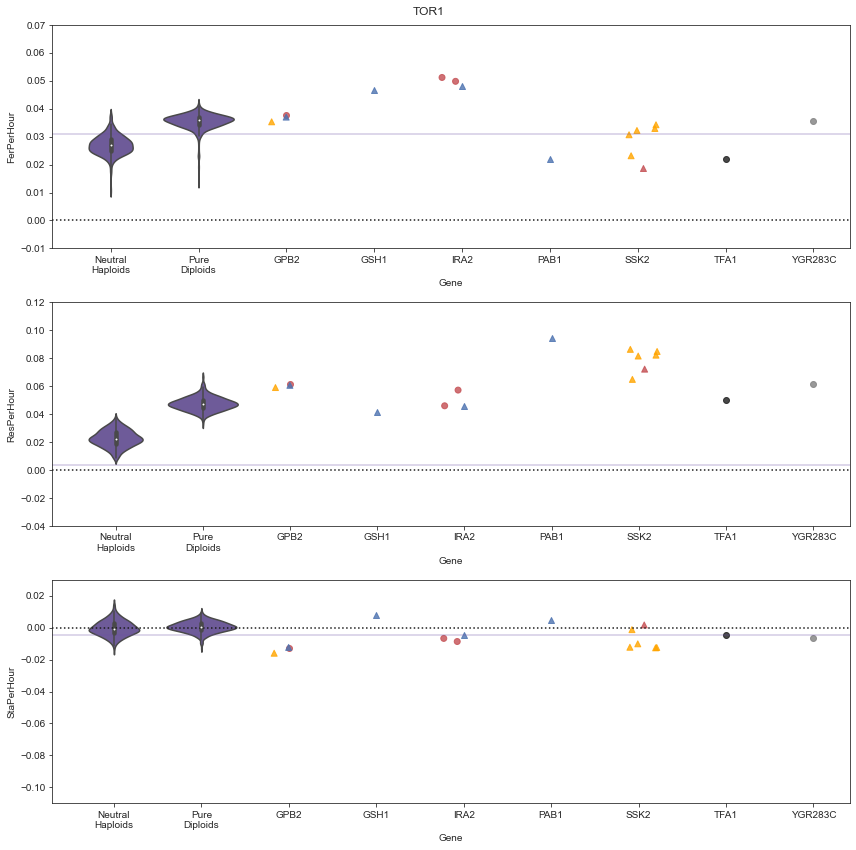

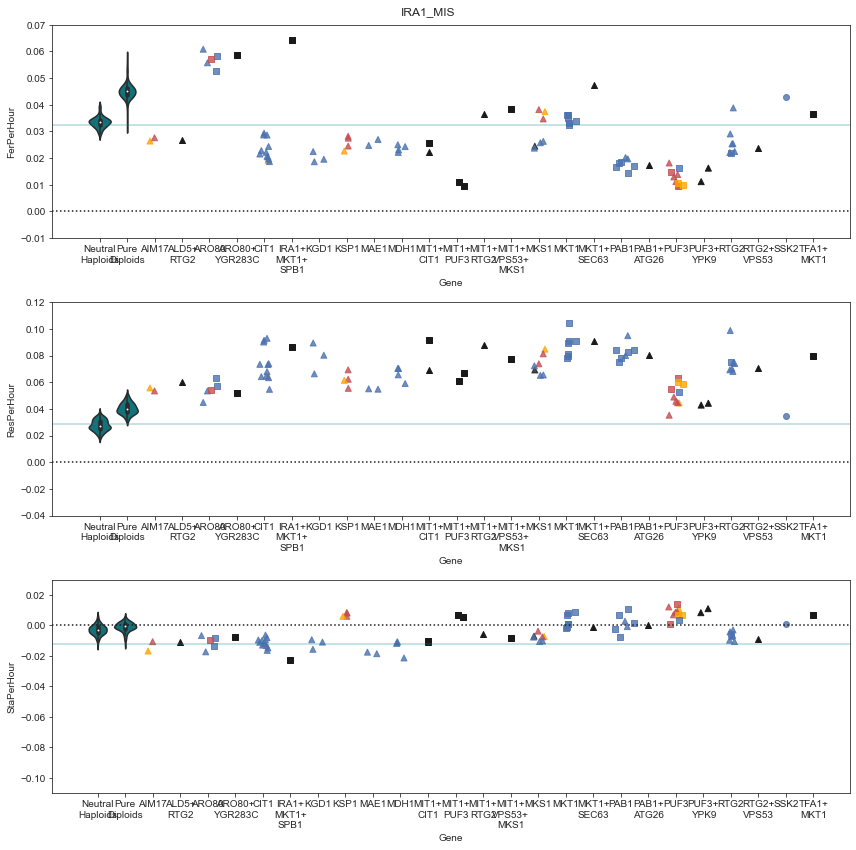

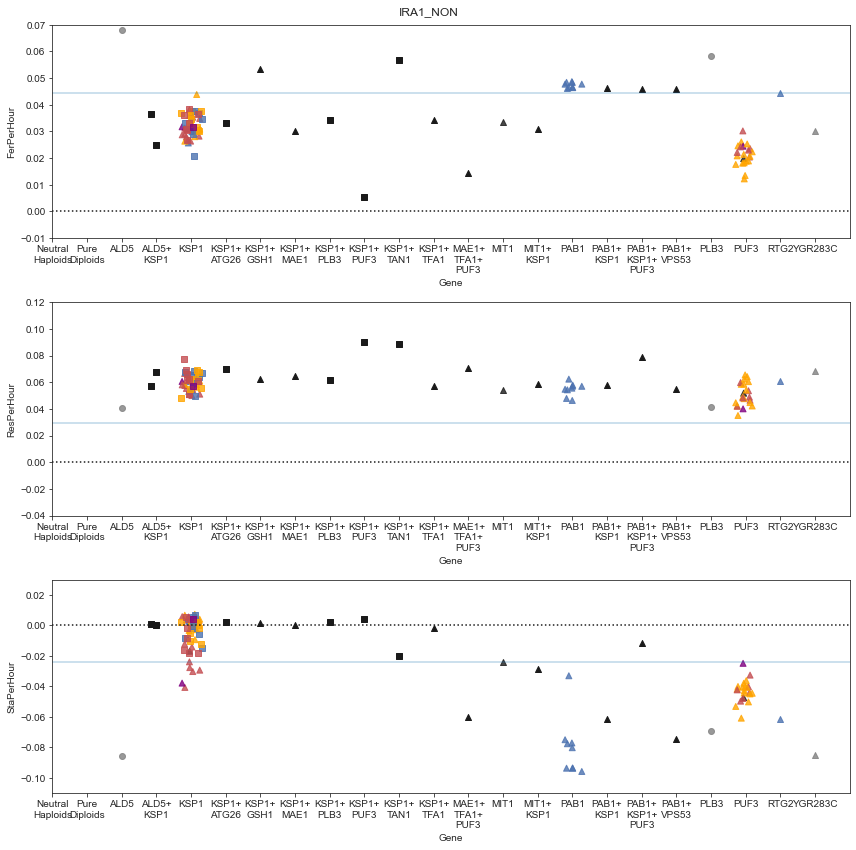

In [31]:

evo_cond_list = ['Evo1D','Evo2D','Evo3D']

plotting_list = ['FerPerHour','ResPerHour','StaPerHour']
# plotting_list = ['Fit1D_both2%5%_fitness','Fit2D_early_fitness',
#                  'Fit3D_both2%5%_fitness','Fit5D_both2%5%_fitness']

effect_color_dictionary = {'stop_gained':'r',
                           'STOP_GAINED':'r',
                     'frameshift_variant':'orange',
                           'frameshift_variantframeshift_variant':'orange',
                           'FRAMESHIFT_VARIANT':'orange',
                           'FRAME_SHIFT':'orange',
                           'CODON_CHANGE_PLUS_CODON_DELETION':'orange',
                           
                    'missense_variant':'b',
                    'NON_SYNONYMOUS_CODING':'b',
                    'synonmymous_variant':'gray',
                    'downstream_gene_variant':'gray',
                    'upstream_gene_variant':'gray',
                          'UPSTREAMUPSTREAM':'gray',
                          'conservative_inframe_deletion':'k',
                          'disruptive_inframe_deletion':'k',
                          'conservative_inframe_insertion':'k',
                          'disruptive_inframe_insertion':'k'}

ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
for a,ancestor in enumerate(ancestor_list):
    
    this_anc = merged_fitness[merged_fitness['ancestor']==ancestor]
    
    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    this_pure_diploid = this_anc[(this_anc['class_new']=='pure_diploids')]
    
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
    this_neutral_haploid = this_anc[(this_anc['class_new']=='neutral_haploids')]

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
    
    gene_list = np.unique([x for x in interesting_muts['gene'].values if not p.isnull(x)])
    
#     gene_list = sorted(gene_list)
        
#     double_muts = [gene for gene in gene_list if '+' in gene]

    fig = plt.figure(figsize=(4*len(plotting_list),12))
    plt.suptitle(f'{ancestor}')
    



    
#     not_featured = interesting_muts[~interesting_muts['gene'].isin([double_mut]+single_muts)]

#     plt.scatter(not_featured[xdata].values,not_featured[ydata].values,
#             color='k',alpha=0.1)



    for count,data in enumerate(plotting_list):
        
        gene_names = []
        plt.subplot(len(plotting_list),1,count+1)
        
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancestor]]

        plt.axhline(background_mutant[data].values,
                color=tools.anc_color_map[ancestor],alpha=0.3)
        
        if len(this_neutral_haploid[data].values) > 0:
            sns.violinplot(x=[0 for x in range(len(this_neutral_haploid[data].values))]+[1 for x in range(len(this_pure_diploid[data].values))],
                           y=list(this_neutral_haploid[data].values)+list(this_pure_diploid[data].values),
                    color=tools.anc_color_map[ancestor],alpha=0.2,thresh=0.2,order=[0,1])

        gene_names.append('Neutral\nHaploids')
        gene_names.append('Pure\nDiploids')

        np.random.seed(9)
        for g,gene in enumerate(gene_list):
            gene_names.append(gene.replace('+','+\n'))
            
            
            for evo_cond in evo_cond_list:
                
                this_gene = interesting_muts[(interesting_muts['gene']==gene) & (interesting_muts['evolution_condition']==evo_cond)]
                
                
                if len(this_gene) > 0:
                    color_list = []
                    for effect in this_gene['effect'].values:
                
                        if '+' in gene:
                            color_list.append('k')
                        else:
                            
                            if effect in effect_color_dictionary:
                                color_list.append(colors.to_rgba(effect_color_dictionary[effect],0.8))
                            else:
                                color_list.append(colors.to_rgba('purple',0.8))
#                             alpha_to_use = 0.

                        if len(this_gene) > 1:
                            x_vals = [tools.jitter_point(g+2) for x in range(len(this_gene))]
                        else:
                            x_vals = [g+2] 

                    plt.scatter(x_vals,this_gene[data].values,
                        color=color_list,label=f'{gene}',marker=tools.evo_cond_marker_map[evo_cond])

#         for evo_cond in evo_cond_list:
#             this_gene = interesting_muts[p.isnull(interesting_muts['gene']) & (~p.isnull(interesting_muts['all_mutations'])) &(interesting_muts['evolution_condition']==evo_cond)]

#             plt.scatter([tools.jitter_point(g+3) for x in range(len(this_gene))],this_gene[data].values,
#                         color='k',label=f'{gene}',alpha=0.1,marker=tools.evo_cond_marker_map[evo_cond])

#         gene_names.append('other')
        
        plt.xticks(range(len(gene_names)),gene_names)

        plt.xlabel('Gene')
        plt.ylabel(data)
        plt.ylim(tools.lims[data][0],tools.lims[data][1])

        plt.axhline(0,color='k',linestyle=':')
            
    plt.tight_layout()
    if 'Fit1D_both2%5%_fitness' in plotting_list:
        plt.savefig(f'{home_dir}/figures/analysis/fitness/fitness_{ancestor}_effect_colors.pdf',bbox_inches='tight')
#         plt.savefig(f'{home_dir}/figures/analysis/fitness/fitness_{ancestor}.png',bbox_inches='tight')
    else:
        plt.savefig(f'{home_dir}/figures/analysis/fitness/performances_{ancestor}_effect_colors.pdf',bbox_inches='tight')




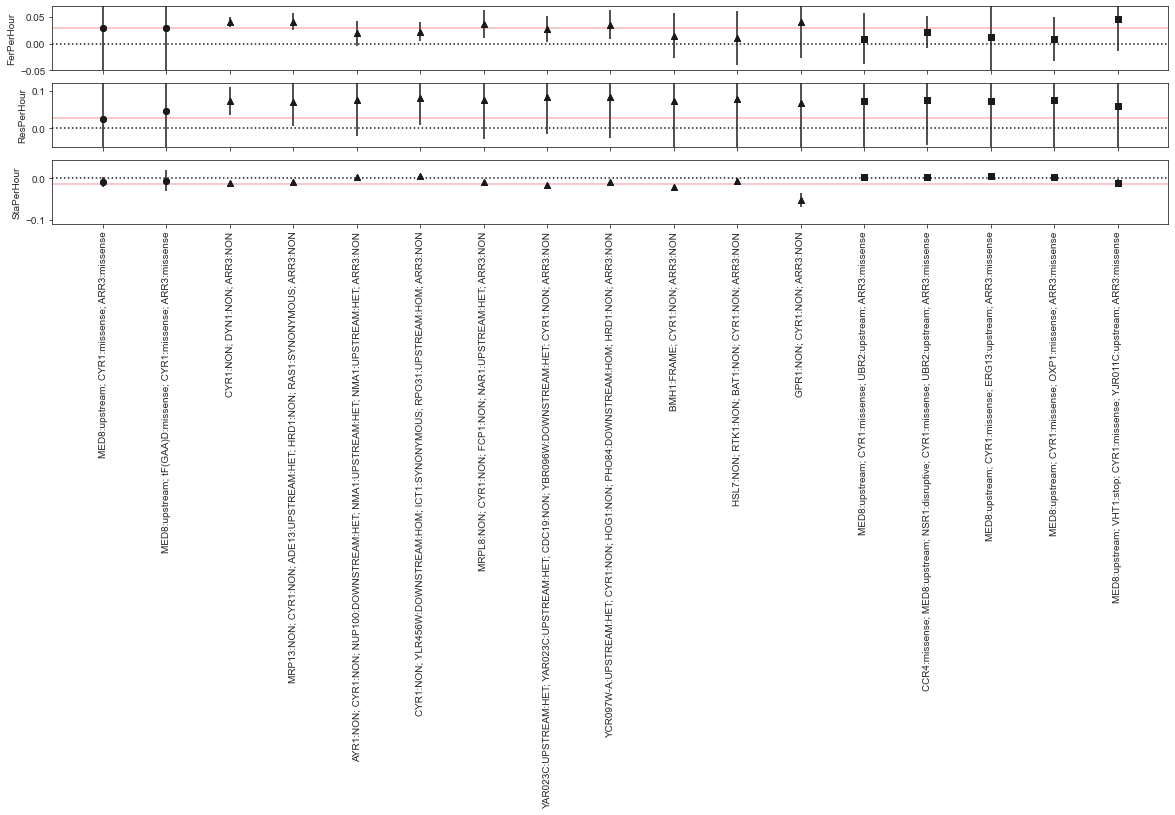

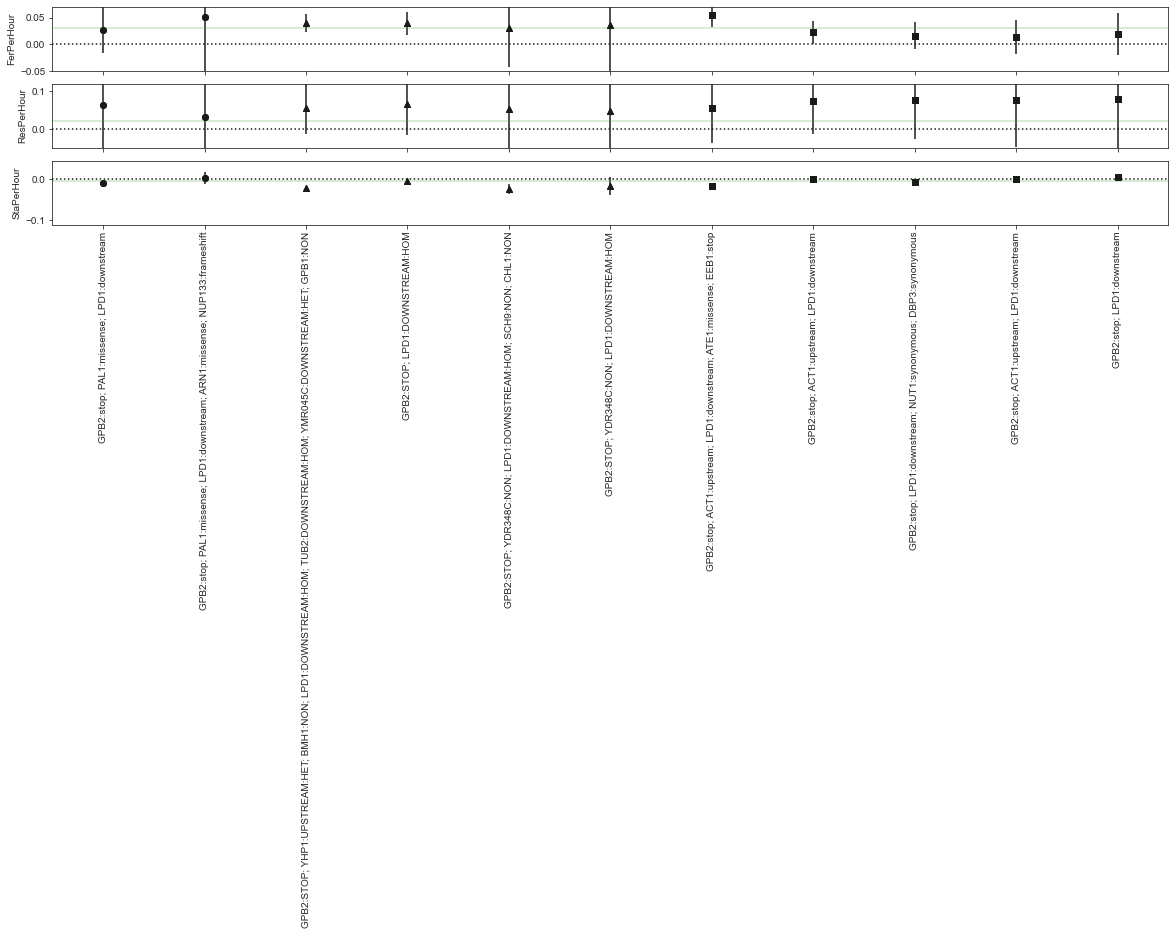

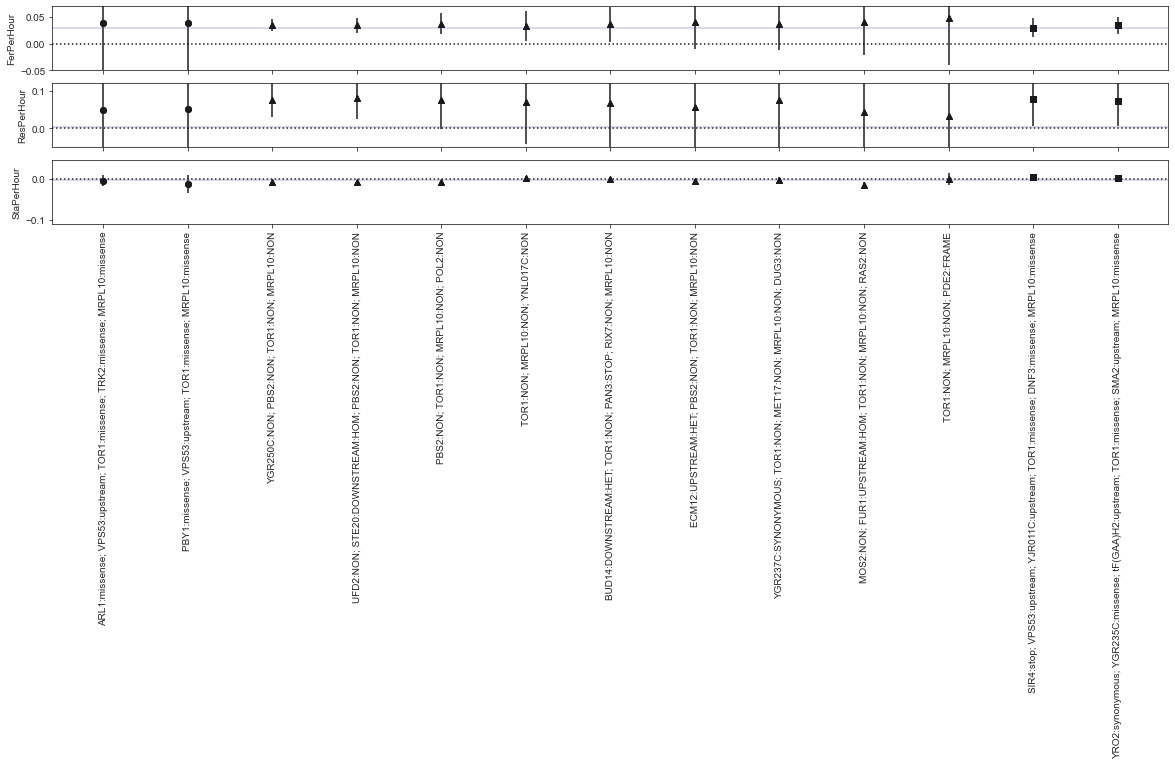

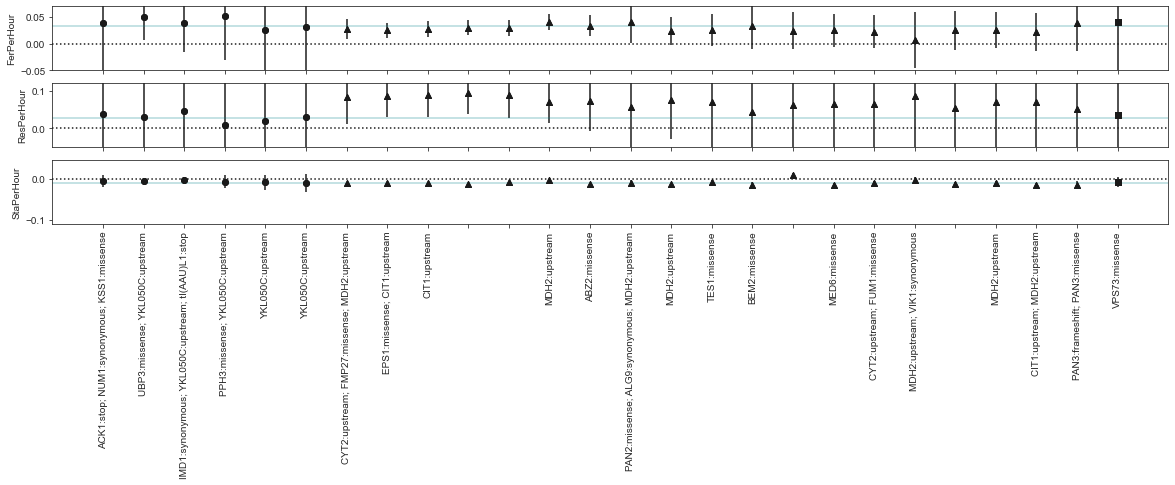

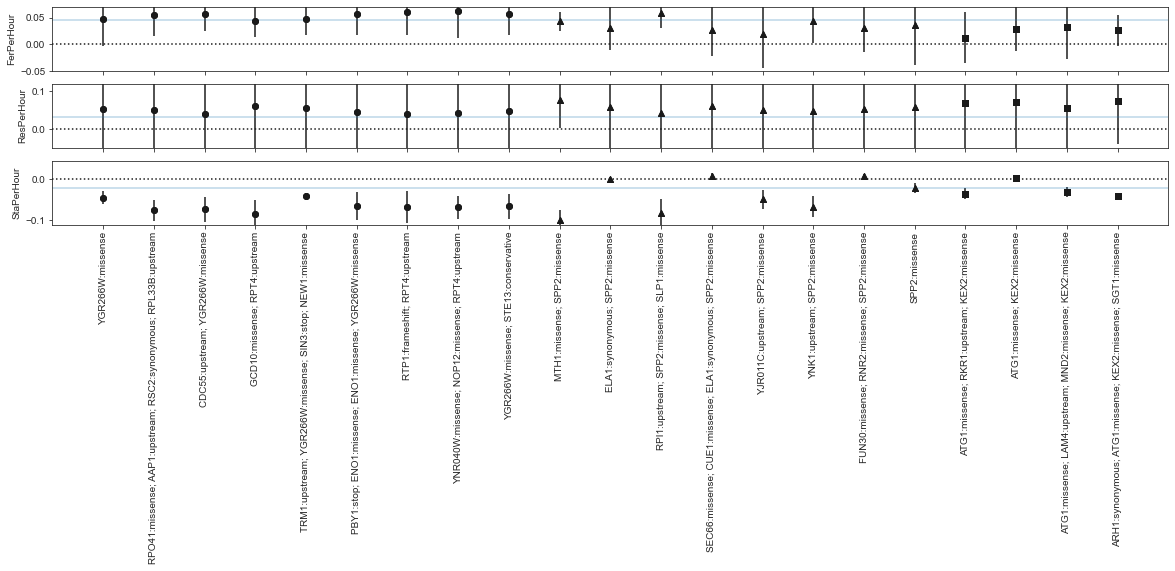

In [82]:

exclusions = {'CYR1':[],
             'GPB2':[],
             'TOR1':[],
             'IRA1_MIS':['IRA1:missense'],
             'IRA1_NON':['IRA1:stop','LPD1:downstream','RPL6B:synonymous']}


ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
for a,ancestor in enumerate(ancestor_list):
    plt.figure(figsize=(20,4))
    
    this_anc = merged_fitness[merged_fitness['ancestor']==ancestor]
    
    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    this_pure_diploid = this_anc[(this_anc['class_new']=='pure_diploids')]
    
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
    this_neutral_haploid = this_anc[(this_anc['class_new']=='neutral_haploids')]

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]



    for count,data in enumerate(plotting_list):

        plt.subplot(3,1,count+1)
        mut_list = []
        for evo_cond in evo_cond_list:



            this_gene = interesting_muts[p.isnull(interesting_muts['gene']) & (~p.isnull(interesting_muts['all_mutations'])) &(interesting_muts['evolution_condition']==evo_cond)]



            plt.ylim(tools.lims[data][0],tools.lims[data][1])

            plt.scatter(range(len(mut_list),len(mut_list)+len(this_gene[data].values)),this_gene[data].values,
                        color='k',label=f'{gene}',alpha=1.0,marker=tools.evo_cond_marker_map[evo_cond])

            plt.errorbar(range(len(mut_list),len(mut_list)+len(this_gene[data].values)),this_gene[data].values,
                         yerr=1*np.sqrt(this_gene[f'{data}_error'].values),linestyle='',
                        color='k',label=f'{gene}',alpha=1.0,marker=tools.evo_cond_marker_map[evo_cond])

            for entry in this_gene['all_mutations']:
                this_entry = []
                for mut in literal_eval(entry):
                    if mut.split('_')[0] not in exclusions[ancestor]:
                        this_entry.append(mut.split('_')[0])

                mut_list.append('; '.join(this_entry))

    #         mut_list = mut_list + [mut.split(':')[0] for entry in this_gene['all_mutations'] for mut in literal_eval(entry)]

        plt.axhline(0,color='k',linestyle=':')
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancestor]]

        plt.axhline(background_mutant[data].values,
                    color=tools.anc_color_map[ancestor],alpha=0.3)
        plt.ylabel(data)
        plt.xticks(range(len(mut_list)),[])

    plt.xticks(range(len(mut_list)),mut_list,rotation=90)


    plt.savefig(f'{home_dir}/figures/analysis/fitness/performances_OtherMuts_{ancestor}.pdf',bbox_inches='tight')

In [57]:
[mut.split(':')[0] for entry in this_gene['all_mutations'] for mut in literal_eval(entry)]

['IRA1',
 'LPD1',
 'ATG1',
 'RPL6B',
 'RKR1',
 'KEX2',
 'IRA1',
 'LPD1',
 'ATG1',
 'RPL6B',
 'KEX2',
 'IRA1',
 'LPD1',
 'ATG1',
 'LAM4',
 'MND2',
 'RPL6B',
 'KEX2',
 'IRA1',
 'ARH1',
 'LPD1',
 'ATG1',
 'RPL6B',
 'KEX2',
 'SGT1']

In [93]:
merged_fitness[(merged_fitness['ancestor']=='CYR1') &
               (merged_fitness['gene']=='PAB1')][['all_mutations','class_new']].values

array([["['MED8:upstream_gene_variant:HOM', 'PAB1:missense_variant:HOM', 'CYR1:missense_variant:HOM', 'UBR2:upstream_gene_variant:HOM', 'IMD4:upstream_gene_variant:HOM', 'ARR3:missense_variant:HOM']",
        'adaptive_haploid'],
       ["['MED8:upstream_gene_variant:HOM', 'PAB1:missense_variant:HOM', 'CYR1:missense_variant:HOM', 'ARR3:missense_variant:HOM']",
        'high_fitness_diploids'],
       ["['PAB1:NON_SYNONYMOUS_CODING:HOM', 'CYR1:NON_SYNONYMOUS_CODING:HOM', 'ARR3:NON_SYNONYMOUS_CODING:HOM']",
        'adaptive_haploid'],
       ["['MED8:upstream_gene_variant:HOM', 'PAB1:missense_variant:HOM', 'CYR1:missense_variant:HOM', 'UBR2:upstream_gene_variant:HOM', 'ARR3:missense_variant:HOM']",
        'high_fitness_diploids'],
       ["['MED8:upstream_gene_variant:HOM', 'PAB1:missense_variant:HOM', 'CYR1:missense_variant:HOM', 'UBR2:upstream_gene_variant:HOM', 'SIN4:missense_variant:HOM', 'ARR3:missense_variant:HOM']",
        'adaptive_haploid']], dtype=object)

In [108]:
plotting_list = ['FerPerHour','ResPerHour','StaPerHour']
plotting_list = 'FerPerHour'
plotting_list = 'ResPerHour'
plotting_list = 'StaPerHour'

ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
for anc1,anc2 in combinations(ancestor_list,2):
    
    interesting_muts1 = merged_fitness[(merged_fitness['ancestor']==anc1) & (~merged_fitness['class_new'].isin(['neutral_haploids','pure_diploids']))]
    interesting_muts2 = merged_fitness[(merged_fitness['ancestor']==anc2) & (~merged_fitness['class_new'].isin(['neutral_haploids','pure_diploids']))]

    out = scipy.stats.ks_2samp(interesting_muts1[plotting_list].values,
                   interesting_muts2[plotting_list].values,
                  )
    print(anc1,anc2,out)

CYR1 GPB2 KstestResult(statistic=0.13242894056847546, pvalue=0.16377653031472994)
CYR1 TOR1 KstestResult(statistic=0.2939189189189189, pvalue=4.430247147135802e-06)
CYR1 IRA1_MIS KstestResult(statistic=0.1657559198542805, pvalue=0.04576888638645327)
CYR1 IRA1_NON KstestResult(statistic=0.2506339326878746, pvalue=1.766844053996408e-05)
GPB2 TOR1 KstestResult(statistic=0.38843494657448147, pvalue=8.131069151318115e-10)
GPB2 IRA1_MIS KstestResult(statistic=0.1986275257338925, pvalue=0.011662426790802538)
GPB2 IRA1_NON KstestResult(statistic=0.29386599761973686, pvalue=6.467069071369735e-07)
TOR1 IRA1_MIS KstestResult(statistic=0.28378378378378377, pvalue=2.91870787006987e-05)
TOR1 IRA1_NON KstestResult(statistic=0.30444656274531795, pvalue=5.059298624487951e-08)
IRA1_MIS IRA1_NON KstestResult(statistic=0.27800829875518673, pvalue=5.048299654197841e-06)


In [104]:
merged_fitness[(merged_fitness['ancestor']==anc1)]['FerPerHour'].values

array([ 0.02867628,  0.04033987,  0.02993363,  0.04875253,  0.00990182,
        0.02323001,  0.02095284,  0.04142127,  0.03992766,  0.04190839,
        0.03065016,  0.01912328,  0.03643527,  0.03993676,  0.02262053,
        0.03625866,  0.02931984,  0.01272005,  0.03945983,  0.03999893,
        0.03745142,  0.04065019,  0.03934093,  0.03897557,  0.03985027,
        0.0109064 ,  0.03607087,  0.016893  ,  0.04017106,  0.04038737,
        0.03862612,  0.03796826,  0.03633097,  0.04113063,  0.03666473,
        0.03781526,  0.03732482,  0.04089235,  0.03792761,  0.03939841,
        0.01799231,  0.03893558,  0.05045247,  0.03502322,  0.03989162,
        0.03641964,  0.00593366,  0.0375513 ,  0.03679444,  0.03942599,
        0.03674355,  0.03183399,  0.04103825,  0.0351123 ,  0.03355452,
        0.04081777,  0.03410691,  0.04144213,  0.03970994,  0.04036077,
        0.0387648 ,  0.03855346,  0.03369121,  0.03930231,  0.03747219,
        0.03794105,  0.03818801,  0.03880162,  0.04167648,  0.03

In [42]:
merged_fitness[merged_fitness['gene']=='CIT1'][['effect','ploidy_new','all_mutations_verbose']].values

array([['missense_variant', 'diploid',
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XIV:630227:C:A:CIT1:missense_variant:c.835G>T:p.Gly279Cys:1/1'],
       ['missense_variant', 'diploid',
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~V:303524:AT:ATT:ALD5:upstream_gene_variant:c.-505_-504insT:nan:0/1~VII:976933:C:T:PFK1:upstream_gene_variant:c.-3199G>A:nan:1/1~XI:486504:G:T:DBP7:missense_variant:c.869C>A:p.Thr290Lys:0/1~XII:401118:T:G:DIP2:missense_variant:c.1462T>G:p.Leu488Val:0/1~XII:1041860:T:C:RIF2:missense_variant:c.1127A>G:p.Tyr376Cys:0/1~XIII:747630:C:A:DFG5:missense_variant:c.1278C>A:p.Asn426Lys:0/1~XIV:630808:C:T:CIT1:missense_variant:c.254G>A:p.Arg85Lys:1/1~XV:87280:AT:A:MDH2:upstream_gene_variant:c.-4361delA:nan:1/1'],
       ['frameshift_variantframeshift_variant', 'haploid',
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XIII:715983:A:G:FSH2:synonymous_variant:c.327T>C:p.Phe109Phe:1/1~XIV:629939:C

In [48]:
merged_fitness[(merged_fitness['gene']=='RTG2')][['ploidy_new','ancestor','all_mutations_verbose']].values

array([['diploid', 'IRA1_MIS',
        'I:127658:C:A:NTG1:missense_variant:c.445G>T:p.Gly149Trp:0/1~II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~VII:26596:A:C:RTG2:missense_variant:c.889T>G:p.Phe297Val:0/1~XV:87280:AT:A:MDH2:upstream_gene_variant:c.-4361delA:nan:1/1'],
       ['haploid', 'IRA1_MIS',
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~VII:26766:C:G:RTG2:missense_variant:c.719G>C:p.Arg240Pro:1/1~VIII:182216:G:A:PUT2:synonymous_variant:c.240G>A:p.Pro80Pro:1/1~XI:111607:C:A:COY1:missense_variant:c.897G>T:p.Gln299His:1/1~XIV:137755:G:C:BSC4:missense_variant:c.57G>C:p.Lys19Asn:1/1'],
       ['diploid', 'GPB2',
        'I:40104:T:G:GPB2:stop_gained:c.846T>G:p.Tyr282*:1/1~VI:58065:C:A:ACT1:upstream_gene_variant:c.-3369G>T:nan:1/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~VII:26586:G:A:RTG2:missense_variant:c.899C>T:p.Ser300Phe:0/1~XIII:128827:C:A:TCB3:missense_variant:c.541G>T:p.Ala181Ser:0/1~XIII:752222:G:C:YHM2:missens